In [1]:
from collections import Counter
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora
import gensim
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from nltk import bigrams
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import numpy as np
from os.path import abspath, join, pardir
import pandas as pd
from PIL import Image
from pprint import pprint
import random
import re
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
import library

In [211]:
reload(library)

<module 'library' from 'C:\\Users\\hugos\\OneDrive\\Nova IMS Doctoral Program\\Publishing\\Paper 3 - Literature review\\Code\\library.py'>

In [212]:
# Defining PROJECT_ROOT
PROJECT_ROOT = abspath(pardir) # NOTE: pardir stands for "parent directory"

In [213]:
# Load data from SCOPUS 
scopus = pd.read_csv(join(PROJECT_ROOT, 'Data', 'scopus_2.csv'), sep=",")

In [214]:
# Load data from Web of Science
wos = pd.read_excel(join(PROJECT_ROOT, 'Data', 'wos_2.xls'))

In [215]:
scopus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Authors                        126 non-null    object 
 1   Author(s) ID                   126 non-null    object 
 2   Title                          126 non-null    object 
 3   Year                           126 non-null    int64  
 4   Source title                   126 non-null    object 
 5   Volume                         92 non-null     object 
 6   Issue                          38 non-null     object 
 7   Art. No.                       17 non-null     float64
 8   Page start                     114 non-null    float64
 9   Page end                       113 non-null    float64
 10  Page count                     4 non-null      float64
 11  Cited by                       94 non-null     float64
 12  DOI                            94 non-null     obj

In [216]:
scopus['Affiliations'][0]

'Department of Computer Science, University of Liverpool, Liverpool, United Kingdom; CIRSFID, Faculty of Law, University of Bologna, Liverpool, Italy'

In [217]:
scopus['Source'].value_counts()

Scopus    126
Name: Source, dtype: int64

In [218]:
wos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 70 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Publication Type            83 non-null     object 
 1   Authors                     83 non-null     object 
 2   Book Authors                0 non-null      float64
 3   Book Editors                45 non-null     object 
 4   Book Group Authors          5 non-null      object 
 5   Author Full Names           83 non-null     object 
 6   Book Author Full Names      0 non-null      float64
 7   Group Authors               0 non-null      float64
 8   Article Title               83 non-null     object 
 9   Source Title                83 non-null     object 
 10  Book Series Title           38 non-null     object 
 11  Book Series Subtitle        0 non-null      float64
 12  Language                    0 non-null      float64
 13  Document Type               83 non-nu

In [219]:
wos['Addresses'][0]

'[Zheng, Heng; Grossi, Davide; Verheij, Bart] Univ Groningen, Bernoulli Inst Math Comp Sci & Artificial Intelli, Groningen, Netherlands; [Grossi, Davide] Univ Amsterdam, Amsterdam Ctr Law & Econ, Amsterdam, Netherlands; [Grossi, Davide] Univ Amsterdam, Inst Log Language & Computat, Amsterdam, Netherlands'

In [220]:
# Create column in WoS to represent the source
wos['Source']='WoS'

In [221]:
# Rename WoS column names to match SCOPUS column names
wos.rename(columns={"Researcher Ids": "Author(s) ID",
                    "Article Title": "Title",
                    "Publication Year": "Year",
                    "Source Title": "Source title",
                    "Addresses": "Correspondence Address",
                    "Times Cited, All Databases": "Cited by"}, inplace=True)

In [222]:
# join the datasets, keep only the matching columns
data = pd.concat([scopus, wos], join="inner", ignore_index=True)

In [223]:
# Dropping research published more than 20 years ago
#data = data[data['Year'] > 2001]

In [224]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Authors                 209 non-null    object 
 1   Author(s) ID            147 non-null    object 
 2   Title                   209 non-null    object 
 3   Year                    207 non-null    float64
 4   Source title            209 non-null    object 
 5   Volume                  156 non-null    object 
 6   Issue                   63 non-null     object 
 7   Cited by                177 non-null    float64
 8   DOI                     152 non-null    object 
 9   Affiliations            195 non-null    object 
 10  Abstract                209 non-null    object 
 11  Author Keywords         169 non-null    object 
 12  Correspondence Address  175 non-null    object 
 13  Publisher               83 non-null     object 
 14  ISSN                    159 non-null    ob

In [225]:
# Creating the 'Country' variable by using Affiliations (primarily) and Correspondence Address (secondarily)

countries = pd.read_csv(join(PROJECT_ROOT, 'Data', 'countries.csv'), sep=",")

In [226]:
data['CountryAff'] = data['Affiliations'].apply(library.createCountry, args=(countries,))

In [227]:
data['CountryAdd'] = data['Correspondence Address'].apply(library.createCountry, args=(countries,))

In [228]:
data['Country'] = data.apply(lambda x: x['CountryAff'] if x['CountryAff'] != 'N.A.' else x['CountryAdd'], axis=1)

In [229]:
data['Country'].value_counts()

N.A.                  42
United States         24
United Kingdom        21
Netherlands           20
India                 13
Germany               11
Poland                11
China                 10
Brazil                 8
Japan                  7
Costa Rica             5
Malaysia               4
Australia              3
Canada                 3
Italy                  3
Lithuania              3
Spain                  2
Egypt                  2
Portugal               2
New Zealand            2
Algeria                2
Botswana               2
Russian Federation     2
Hong Kong              2
Ecuador                1
Pakistan               1
Romania                1
Ireland                1
France                 1
Name: Country, dtype: int64

In [230]:
data['Authors'].isna().sum()

0

In [231]:
data['Authors'].duplicated().value_counts()

False    186
True      23
Name: Authors, dtype: int64

In [232]:
data['DOI'].duplicated().value_counts()

False    109
True     100
Name: DOI, dtype: int64

In [233]:
data['Title'].duplicated().value_counts()

False    179
True      30
Name: Title, dtype: int64

In [234]:
data.duplicated().value_counts()

False    209
dtype: int64

In [235]:
# create a working copy of the dataset
ds = data.copy(deep=True)

In [236]:
ds['TitleCleaned'] = ds['Title'].apply(library.cleaner)

In [237]:
ds['TitleCleaned'].duplicated().value_counts()

False    154
True      55
Name: TitleCleaned, dtype: int64

In [238]:
# Dropping duplicated papers by title
ds.drop_duplicates(subset=['TitleCleaned'], keep='first', inplace=True)

In [239]:
ds['Source'].value_counts()

Scopus    126
WoS        28
Name: Source, dtype: int64

In [240]:
# Checking for duplicates by DOI
ds.dropna().loc[ds['DOI'].duplicated()]

,Authors,Author(s) ID,Title,Year,Source title,Volume,Issue,Cited by,DOI,Affiliations,...,Correspondence Address,Publisher,ISSN,ISBN,Document Type,Source,CountryAff,CountryAdd,Country,TitleCleaned


In [241]:
# Checking for for nans in DOI
ds['DOI'].isna().sum()

45

In [242]:
# Cleaning DOI to re-check for duplicates

ds['DOICleaned'] = ds['DOI'].astype(str).apply(library.cleaner)

In [243]:
ds['DOI']

0      10.1016/S0004-3702(03)00108-5
1      10.1016/S0004-3702(03)00105-X
2          10.1007/s10506-009-9077-9
3            10.1145/1047788.1047838
4        10.1007/978-3-642-12837-0_4
                   ...              
189        10.1007/s10506-017-9216-7
190                              NaN
194                              NaN
197           10.1515/fman-2015-0028
208                              NaN
Name: DOI, Length: 154, dtype: object

In [244]:
ds.dropna().loc[ds['DOICleaned'].duplicated()]

,Authors,Author(s) ID,Title,Year,Source title,Volume,Issue,Cited by,DOI,Affiliations,...,Publisher,ISSN,ISBN,Document Type,Source,CountryAff,CountryAdd,Country,TitleCleaned,DOICleaned


In [245]:
# Checking for duplicates by Abstract
ds.dropna().loc[ds['Abstract'].duplicated()]

,Authors,Author(s) ID,Title,Year,Source title,Volume,Issue,Cited by,DOI,Affiliations,...,Publisher,ISSN,ISBN,Document Type,Source,CountryAff,CountryAdd,Country,TitleCleaned,DOICleaned


In [246]:
ds['AbstractCleaned'] = ds['Abstract'].astype(str).apply(library.cleaner)

In [247]:
ds['KeywordsCleaned'] = ds['Author Keywords'].astype(str).apply(library.cleaner)

In [248]:
ds.dropna().loc[ds['AbstractCleaned'].duplicated()]

,Authors,Author(s) ID,Title,Year,Source title,Volume,Issue,Cited by,DOI,Affiliations,...,ISBN,Document Type,Source,CountryAff,CountryAdd,Country,TitleCleaned,DOICleaned,AbstractCleaned,KeywordsCleaned


In [249]:
ds['TitleTokens'] = ds['TitleCleaned'].astype(str).apply(library.tokenizer_stemmer)

In [250]:
#tokenizing and stemming Title resulted in finding one more duplicate

ds['TitleTokens'].duplicated().value_counts()

False    153
True       1
Name: TitleTokens, dtype: int64

In [251]:
ds[ds['TitleTokens'].duplicated(keep=False)]

,Authors,Author(s) ID,Title,Year,Source title,Volume,Issue,Cited by,DOI,Affiliations,...,Document Type,Source,CountryAff,CountryAdd,Country,TitleCleaned,DOICleaned,AbstractCleaned,KeywordsCleaned,TitleTokens
16,Nissan E.,7006461822;,Digital technologies and artificial intelligen...,2017.0,AI and Society,32,3,25.0,10.1007/s00146-015-0596-5,"Department of Computing, Goldsmiths’ College, ...",...,Article,Scopus,United Kingdom,United Kingdom,United Kingdom,digital technologies and artificial intelligen...,101007s0014601505965,‘ai law’ research has been around since the 1...,ai law argumentation casebased reasoning crim...,digit technologi artific intelligenc present f...
142,"Nissan, E",NaN,Digital technologies and artificial intelligen...,2017.0,AI & SOCIETY,32,3,20.0,10.1007/s00146-015-0596-5,University of London; Goldsmiths University Lo...,...,Article,WoS,N.A.,N.A.,N.A.,digital technologies and artificial intelligen...,101007s0014601505965,ai law research has been around since the 197...,ai law policing lawyering prosecuting sentenc...,digit technologi artific intelligenc present f...


In [252]:
# Dropping duplicated papers by tokenized/stemmed Title
ds.drop_duplicates(subset=['TitleTokens'], keep='first', inplace=True)

In [253]:
ds['AbstractTokens'] = ds['AbstractCleaned'].astype(str).apply(library.tokenizer_stemmer)

In [254]:
ds['KeywordsTokens'] = ds['KeywordsCleaned'].astype(str).apply(library.tokenizer_stemmer)

In [255]:
#tokenizing and stemming Abstract resulted in finding two more duplicates

ds['AbstractTokens'].duplicated().value_counts()

False    153
Name: AbstractTokens, dtype: int64

In [256]:
ds['Source'].value_counts()

Scopus    126
WoS        27
Name: Source, dtype: int64

In [257]:
ds = ds.sort_values(by='Year', ascending=False).reset_index(drop=True)

In [258]:
#### TF-IDF vectorization and Cosine Similarities ####

#vectorizer
nGramRangeDict = {'Uni': (1,1),
                  'Bi': (2,2)}

library.cosineSimilarities(nGramRangeDict, ds, 'TitleTokens', PROJECT_ROOT)

Creating TF-IDF vectorizer for ngramrange=(1, 1)...
Calculating cosine similarity for Unigrams ...
Creating TF-IDF vectorizer for ngramrange=(2, 2)...
Calculating cosine similarity for Bigrams ...


In [259]:
possibleDuplicates = []
c = 'TitleTokens'

for key, value in nGramRangeDict.items():
    simData = pd.read_csv(join(PROJECT_ROOT, 'Results', f'tfidf_{key}grams_{c}.csv'), sep=",", index_col=0)
    for column in simData.columns:
        for index in simData.index:
            if ((simData.loc[index, column] >= 0.9) and (simData.loc[index, column] < 1)):
                column = str(column)
                index = str(index)
                if ((column, index) not in possibleDuplicates) and ((index, column) not in possibleDuplicates) and index != column:
                    possibleDuplicates.append((index, column))               

In [260]:
possibleDuplicates

[('30', '28'), ('55', '44')]

In [261]:
# Found two more duplicates, published in different journals

for index, column in possibleDuplicates:
    pprint(ds.loc[[int(index),int(column)], ['Title', 'Publisher', 'Authors', 'Year']])

                                                Title  \
30  Overview of the FIRE 2019 AILA track: Artifici...   
28  FIRE 2019 AILA track: Artificial intelligence ...   

                              Publisher  \
30                              CEUR-WS   
28  Association for Computing Machinery   

                                              Authors    Year  
30  Bhattacharya P., Ghosh K., Ghosh S., Pal A., M...  2019.0  
28  Bhattacharya P., Ghosh K., Ghosh S., Pal A., M...  2019.0  
                                                Title   Publisher  \
55     Goal trajectories for knowledge investigations     CEUR-WS   
44  Case-based goal trajectories for knowledge inv...  AAAI Press   

                                              Authors    Year  
55  Eyorokon V.B., Bengfort B., Panjala U.S., Cox ...  2016.0  
44                Eyorokon V.B., Panjala U., Cox M.T.  2017.0  


In [262]:
for tup in possibleDuplicates:
    ds.drop(int(max(tup[0], tup[1])), inplace=True)

In [263]:
# The same now using Abstract

library.cosineSimilarities(nGramRangeDict, ds, 'AbstractTokens', PROJECT_ROOT)

Creating TF-IDF vectorizer for ngramrange=(1, 1)...
Calculating cosine similarity for Unigrams ...
Creating TF-IDF vectorizer for ngramrange=(2, 2)...
Calculating cosine similarity for Bigrams ...


In [264]:
possibleDuplicates = []
c = 'AbstractTokens'

for key, value in nGramRangeDict.items():
    simData = pd.read_csv(join(PROJECT_ROOT, 'Results', f'tfidf_{key}grams_{c}.csv'), sep=",", index_col=0)
    for column in simData.columns:
        for index in simData.index:
            if ((simData.loc[index, column] >= 0.8) and (simData.loc[index, column] < 1)):
                column = str(column)
                index = str(index)
                if ((column, index) not in possibleDuplicates) and ((index, column) not in possibleDuplicates) and index != column:
                    possibleDuplicates.append((index, column))               

In [265]:
possibleDuplicates

[('59', '56'), ('110', '95')]

In [266]:
# Found versions of the same two papers, we'll keep the most recent

for index, column in possibleDuplicates:
    print(ds.loc[[int(index),int(column)], ['Title', 'Publisher', 'Authors', 'Abstract', 'Year']])

                                                Title Publisher  \
59  SITUATIONAL MANAGEMENT OF CRITICAL INFRASTRUCT...       NaN   
56  CONCEPT OF SITUATIONAL MANAGEMENT OF SAFETY CR...       NaN   

                    Authors  \
59  Krupa, T; Wisniewski, M   
56            Wisniewski, M   

                                             Abstract    Year  
59  This article presents a synthesis of knowledge...  2015.0  
56  This article presents a synthesis of knowledge...  2016.0  
                                                 Title  Publisher  \
110  A case study of hypothetical and value-based r...  IOS Press   
95   Using argument schemes for hypothetical reason...        NaN   

                        Authors  \
110  Bench-Capon T., Prakken H.   
95   Bench-Capon T., Prakken H.   

                                              Abstract    Year  
110  This paper studies the use of hypothetical and...  2009.0  
95   This paper studies the use of hypothetical and...  2010.0  


In [267]:
for tup in possibleDuplicates:
    ds.drop(int(max(tup[0], tup[1])), inplace=True)

In [268]:
ds['Source'].value_counts()

Scopus    123
WoS        26
Name: Source, dtype: int64

In [269]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 152
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Authors                 149 non-null    object 
 1   Author(s) ID            127 non-null    object 
 2   Title                   149 non-null    object 
 3   Year                    148 non-null    float64
 4   Source title            149 non-null    object 
 5   Volume                  107 non-null    object 
 6   Issue                   41 non-null     object 
 7   Cited by                117 non-null    float64
 8   DOI                     106 non-null    object 
 9   Affiliations            138 non-null    object 
 10  Abstract                149 non-null    object 
 11  Author Keywords         117 non-null    object 
 12  Correspondence Address  118 non-null    object 
 13  Publisher               81 non-null     object 
 14  ISSN                    108 non-null    ob

In [270]:
ds['Document Type'].value_counts()

Conference Paper         68
Article                  41
Proceedings Paper        21
Book Chapter              8
Conference Review         5
Review                    3
Book                      2
Article; Early Access     1
Name: Document Type, dtype: int64

In [271]:
sourceTitle = ds.groupby('Source title')

In [272]:
sourceTitle.filter(lambda x: len(x) > 1).groupby('Source title')

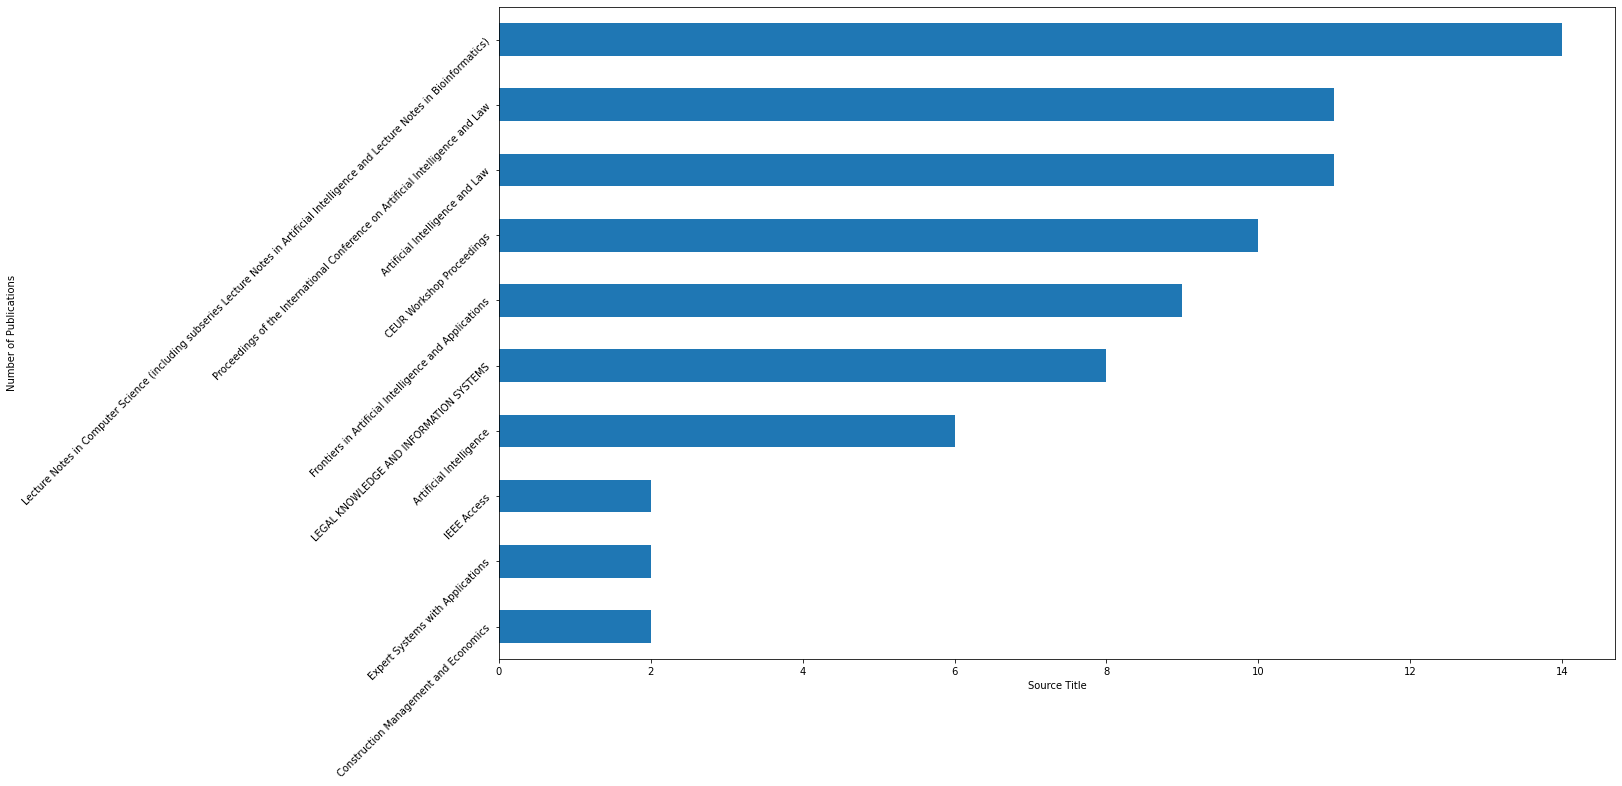

In [273]:
plt.figure(figsize=(20,12))
sourceTitle.filter(lambda x: len(x) > 1).groupby('Source title').size().sort_values(ascending=True).plot.barh()
plt.yticks(rotation=45)
plt.xlabel("Source Title")
plt.ylabel("Number of Publications")
plt.show()

In [274]:
country = ds.groupby('Country')

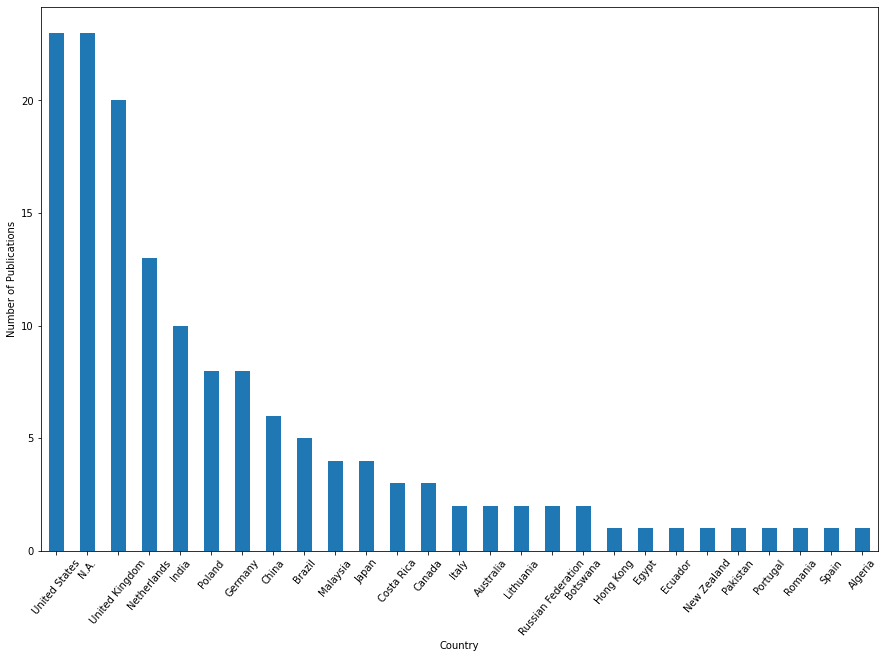

In [275]:
plt.figure(figsize=(15,10))
country.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Country")
plt.ylabel("Number of Publications")
plt.show()

In [276]:
pubPerYear = ds.groupby('Year').count()['Authors']
pubPerYear

Year
2002.0     5
2003.0    14
2004.0     4
2005.0     3
2006.0     5
2007.0     4
2008.0     6
2009.0    10
2010.0     7
2011.0    12
2012.0     2
2013.0     7
2014.0     7
2015.0     5
2016.0     4
2017.0    13
2018.0     6
2019.0    11
2020.0     9
2021.0    12
2022.0     2
Name: Authors, dtype: int64

In [277]:
pubPerYearAndCountry = pd.pivot_table(ds, values='Authors', index='Year', columns='Country', aggfunc='count').fillna(0)
pubPerYearAndCountry = pubPerYearAndCountry.drop('N.A.', axis = 1)

In [278]:
fields = pubPerYearAndCountry.columns.tolist()
labels = pubPerYearAndCountry.index.tolist()

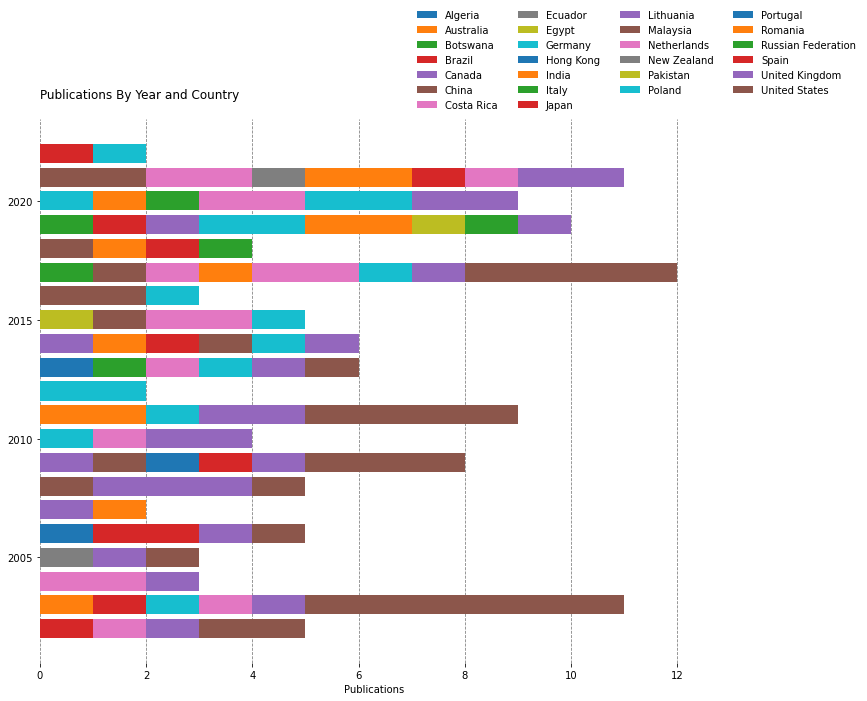

In [279]:
#colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748']

# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))
# plot bars
left = len(pubPerYearAndCountry) * [0]
for idx, name in enumerate(fields):
    plt.barh(pubPerYearAndCountry.index, pubPerYearAndCountry[name], left = left)
    left = left + pubPerYearAndCountry[name]
# title, legend, labels
plt.title('Publications By Year and Country\n', loc='left')
plt.legend(fields, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Publications')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
#plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

In [280]:
abstractText = " ".join(abstract for abstract in ds['AbstractTokens'])
print ("There are {} words in the combination of all tokenized abstracts.".format(len(abstractText)))

There are 104194 words in the combination of all tokenized abstracts.


In [281]:
freqWords = FreqDist(word.lower() for word in word_tokenize(abstractText))

In [282]:
len(freqWords.items())

3109

In [283]:
freqWords

FreqDist({'cas': 357, 'legal': 313, 'reasoning': 221, 'syst': 180, 'law': 145, 'casebased': 129, 'pap': 123, 'model': 111, 'approach': 102, 'based': 85, ...})

In [284]:
# Let's take the specific words only if their size is greater than 2.
filter_words = dict([(m, n) for m, n in freqWords.items() if len(m) > 2])

In [285]:
len(filter_words)

3086

In [286]:
data_analysis = FreqDist(filter_words)

In [287]:
pd.Series(data_analysis).sort_values(ascending=True)

fam                1
rout               1
appropriately      1
expertnes          1
tangibl            1
                ... 
law              145
syst             180
reasoning        221
legal            313
cas              357
Length: 3086, dtype: int64

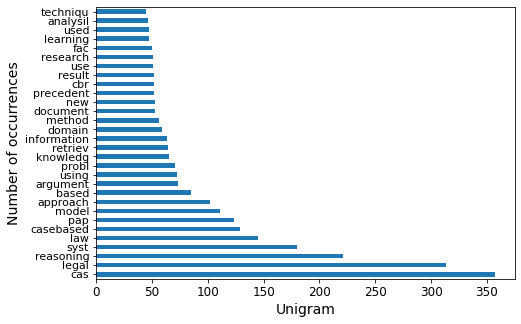

In [288]:
plt.figure(figsize=(7.5,5))
pd.Series(data_analysis).sort_values(ascending=False)[0:30].plot.barh()
plt.xticks(fontsize=12)
plt.yticks(fontsize=11)
plt.xlabel("Unigram", fontsize=14)
plt.ylabel("Number of occurrences", fontsize=14)
#plt.show()
plt.savefig(join(PROJECT_ROOT, 'Images', 'unigramFreqDist.png'))

In [289]:
wordCount = pd.Series(data_analysis).sort_values(ascending=False)
print(wordCount[wordCount > 30])

cas               357
legal             313
reasoning         221
syst              180
law               145
casebased         129
pap               123
model             111
approach          102
based              85
argument           73
using              72
probl              71
knowledg           65
retriev            64
information        63
domain             59
method             56
document           53
new                53
precedent          52
cbr                52
result             52
use                51
research           51
fac                50
learning           47
used               47
analysil           46
techniqu           45
support            44
rul                44
fact               41
work               41
different          38
dat                37
present            37
provid             36
term               36
two                36
court              36
similarity         35
right              35
relevant           35
one                35
valu      

In [290]:
# remove non-discriminative words
stopwords = set(STOPWORDS)
stopwords.update(["legal",
                  "law",
                  "pap",
                  "new",
                  "research",
                  "result",
                  "using",
                  "used",
                  "use",
                  "analysil",
                  "two",
                  "work",
                  "one",
                  "elsevi",
                  "right",
                  "reserved",
                  "study",
                  "proposed",
                  "berlin",
                  "heidelberg",
                  "spring",
                  "natur",
                  "ieee"])

In [291]:
from sklearn.feature_extraction import text 

stopwords = text.ENGLISH_STOP_WORDS.union(stopwords)

In [292]:
unigrams_list = list(word_tokenize(abstractText))

In [293]:
#Using count vectoriser to view the frequency of unigrams
vectorizer = CountVectorizer(ngram_range=(1, 1), stop_words=stopwords, max_df=0.5)
bag_of_words = vectorizer.fit_transform(ds['AbstractTokens'])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:391: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.



In [294]:
vectorizer.stop_words_

{'cas', 'casebased', 'reasoning'}

In [295]:
len(words_freq)

2999

In [296]:
# filter unigrams with more than 10 occurrences
words_freq = [tup for tup in words_freq if tup[1] > 10]

In [297]:
len(words_freq)

208

In [298]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

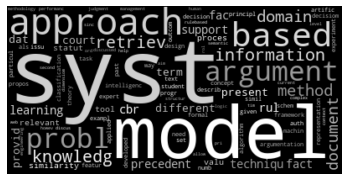

In [299]:
#Generating wordcloud and saving as jpg image
words_dict = dict(words_freq)
wordCloud = WordCloud(background_color="black", stopwords=stopwords, max_words=100)
wordCloud.generate_from_frequencies(words_dict)
#plt.title('Most frequently occurring unigrams connected by same colour and font size')
default_colors = wordCloud.to_array()
plt.imshow(wordCloud.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
#plt.imshow(wordCloud, interpolation='bilinear')
#plt.figure(figsize=(7.5,5))
plt.axis("off")
plt.show()
wordCloud.to_file(join(PROJECT_ROOT, 'Images', 'wordCloudUnigram.png'))

In [300]:
list(bigrams(word_tokenize(abstractText)))

[('fam', 'german'),
 ('german', 'pap'),
 ('pap', 'juristisch'),
 ('juristisch', 'schlüss'),
 ('schlüss', 'fortior'),
 ('fortior', 'und'),
 ('und', 'par'),
 ('par', '1965'),
 ('1965', 'alchourron'),
 ('alchourron', 'developed'),
 ('developed', 'model'),
 ('model', 'analogi'),
 ('analogi', 'taking'),
 ('taking', 'consideration'),
 ('consideration', 'different'),
 ('different', 'typ'),
 ('typ', 'legal'),
 ('legal', 'rul'),
 ('rul', 'taking'),
 ('taking', 'starting'),
 ('starting', 'point'),
 ('point', 'develop'),
 ('develop', 'formal'),
 ('formal', 'model'),
 ('model', 'going'),
 ('going', 'deep'),
 ('deep', 'jurisprudenc'),
 ('jurisprudenc', 'referring'),
 ('referring', 'balancing'),
 ('balancing', 'interest'),
 ('interest', 'model'),
 ('model', 'deal'),
 ('deal', 'analogi'),
 ('analogi', 'based'),
 ('based', 'afortioriargument'),
 ('afortioriargument', 'apariargument'),
 ('apariargument', 'asimileargument'),
 ('asimileargument', '2022'),
 ('2022', 'spring'),
 ('spring', 'natur'),
 ('nat

In [301]:
freqBigrams = FreqDist(bigrams(word_tokenize(abstractText)))
freqBigrams

FreqDist({('casebased', 'reasoning'): 98, ('legal', 'cas'): 37, ('legal', 'reasoning'): 30, ('artific', 'intelligenc'): 28, ('legal', 'domain'): 25, ('right', 'reserved'): 24, ('pri', 'cas'): 18, ('machin', 'learning'): 17, ('reasoning', 'cbr'): 17, ('pap', 'present'): 16, ...})

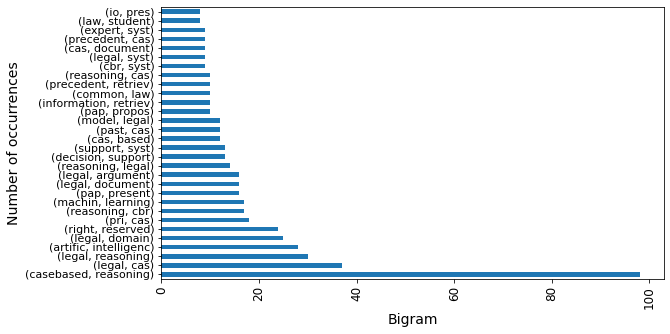

In [302]:
plt.figure(figsize=(9,5))
pd.Series(freqBigrams).sort_values(ascending=False)[0:30].plot.barh()
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=11)
plt.xlabel("Bigram", fontsize=14)
plt.ylabel("Number of occurrences", fontsize=14)
#plt.show()
plt.savefig(join(PROJECT_ROOT, 'Images', 'bigramFreqDist.png'))

In [303]:
bigrams_list = list(bigrams((word_tokenize(abstractText))))
dictionary2 = [' '.join(tup) for tup in bigrams_list]

In [304]:
len(dictionary2)

13559

In [305]:
#Using count vectoriser to view the frequency of bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=stopwords, max_df=0.3)
bag_of_words = vectorizer.fit_transform(ds['AbstractTokens'])
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:391: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.



In [306]:
vectorizer.stop_words_

{'casebased reasoning'}

In [307]:
print(len(words_freq))
# filter unigrams with more than 10 occurrences
words_freq = [tup for tup in words_freq if tup[1] > 3]
print(len(words_freq))

10199
112


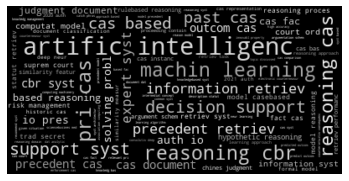

In [308]:
#Generating wordcloud and saving as jpg image
words_dict = dict(words_freq)
wordCloud = WordCloud(background_color="black", stopwords=stopwords, max_words=100)
wordCloud.generate_from_frequencies(words_dict)
#plt.title('Most frequently occurring bigrams connected by same colour and font size')
default_colors = wordCloud.to_array()
plt.imshow(wordCloud.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
#plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordCloud.to_file(join(PROJECT_ROOT, 'Images', 'wordCloudBigram.png'))

In [309]:
words_dict

{'artific intelligenc': 28,
 'pri cas': 18,
 'machin learning': 17,
 'reasoning cbr': 17,
 'reasoning cas': 16,
 'support syst': 13,
 'decision support': 13,
 'cas based': 12,
 'past cas': 12,
 'information retriev': 10,
 'precedent retriev': 10,
 'expert syst': 9,
 'precedent cas': 9,
 'cas document': 9,
 'cbr syst': 9,
 'outcom cas': 9,
 'solving probl': 8,
 'io pres': 8,
 'auth io': 8,
 'based reasoning': 8,
 'cas fac': 8,
 'judgment document': 7,
 'information syst': 7,
 'court ord': 7,
 'computat model': 7,
 'hypothetic reasoning': 7,
 'retriev syst': 6,
 'suprem court': 6,
 'model casebased': 6,
 'trad secret': 6,
 'fact cas': 6,
 'risk management': 6,
 'reasoning proces': 6,
 'model reasoning': 6,
 'statut retriev': 6,
 'rulebased reasoning': 6,
 'chines judgment': 6,
 'cas bas': 6,
 'argument schem': 6,
 'retriev performanc': 6,
 'cas instanc': 6,
 'similarity featur': 6,
 'formal model': 5,
 '2021 auth': 5,
 'similarity measur': 5,
 'historic cas': 5,
 'deep neur': 5,
 'docume

In [310]:
bigramsOfInterest = ['artific intelligenc', 'machin learning', 'decision support', 'computat model', 'syst']

In [311]:
selectedPapers = []
for row in ds.iterrows():
    for bigram in bigramsOfInterest:
        for column in ['AbstractTokens', 'KeywordsTokens', 'TitleTokens']:
            if re.search(bigram, row[1][column]):
                selectedPapers.append(row[0])
selectedPapers = list(set(selectedPapers))

In [312]:
len(selectedPapers)

93

In [313]:
dsSelected = ds.loc[selectedPapers]

In [314]:
dsSelected['Source'].value_counts()

Scopus    79
WoS       14
Name: Source, dtype: int64

### Topic Modeling with LDA
#### maximize coherence and minimize the topic overlap

In [107]:
dsSelected['corpus'] = dsSelected['AbstractTokens'] + ' ' + dsSelected['TitleTokens'] + ' ' + dsSelected['KeywordsTokens']

In [108]:
corpus = dsSelected['corpus'].apply(lambda x: x.split(' '))

In [109]:
dsSelected['Title']

1      A knowledge-based system for electric motors c...
2      Constructing the Electronic Countermeasures Sy...
3      Resolving counterintuitive consequences in law...
5      Unsupervised approaches for measuring textual ...
6      Practical tools from formal models: The ECHR a...
                             ...                        
142    Structured contextual search for the un securi...
143    Classification and clustering for case-based c...
145    Using background knowledge in case-based legal...
149    An Australian perspective on research and deve...
151    Information technology knowledge sharing using...
Name: Title, Length: 93, dtype: object

In [110]:
dirichlet_dict = corpora.Dictionary(corpus)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in corpus]

In [111]:
# Considering 1-12 topics, as the last is cut off
num_topics = list(range(13)[1:])
num_keywords = 12

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=bow_corpus,
                             id2word=dirichlet_dict,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(bow_corpus),
                             passes=20,
                             alpha='auto',
                             random_state=42)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [112]:
# Use the above to derive the mean stability across topics by considering the next topic

LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(library.jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [113]:
coherences = [CoherenceModel(model=LDA_models[i], texts=corpus, dictionary=dirichlet_dict, coherence='c_v').get_coherence()\
              for i in num_topics[:-1]]

In [114]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

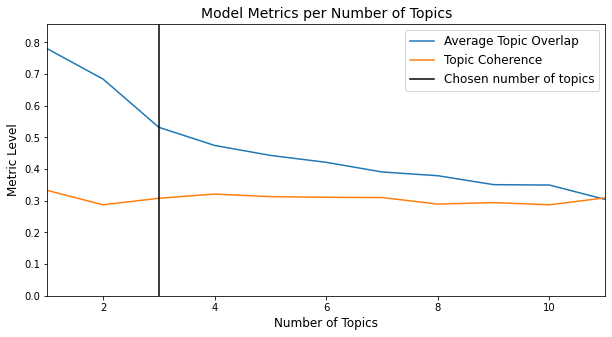

In [115]:
plt.figure(figsize=(10,5))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

#ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvline(x=3, label='Chosen number of topics', color='black')
#ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=14)
ax.set_ylabel('Metric Level', fontsize=12)
ax.set_xlabel('Number of Topics', fontsize=12)
plt.legend(fontsize=12)
plt.show()

### LDA model with 3 topics

In [116]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                           id2word=dirichlet_dict,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [117]:
pprint(lda_model.print_topics())

[(0,
  '0.036*"cas" + 0.021*"retriev" + 0.019*"legal" + 0.015*"information" + '
  '0.010*"syst" + 0.009*"classification" + 0.008*"precedent" + 0.008*"text" + '
  '0.007*"document" + 0.007*"management"'),
 (1,
  '0.024*"cas" + 0.018*"model" + 0.016*"argument" + 0.015*"reasoning" + '
  '0.013*"argumentation" + 0.011*"casebased" + 0.011*"cat" + 0.011*"legal" + '
  '0.010*"based" + 0.009*"learning"'),
 (2,
  '0.035*"syst" + 0.033*"legal" + 0.031*"reasoning" + 0.022*"casebased" + '
  '0.018*"law" + 0.015*"support" + 0.011*"decision" + 0.010*"research" + '
  '0.010*"cbr" + 0.008*"knowledg"')]


### Word Counts of Topic Keywords

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


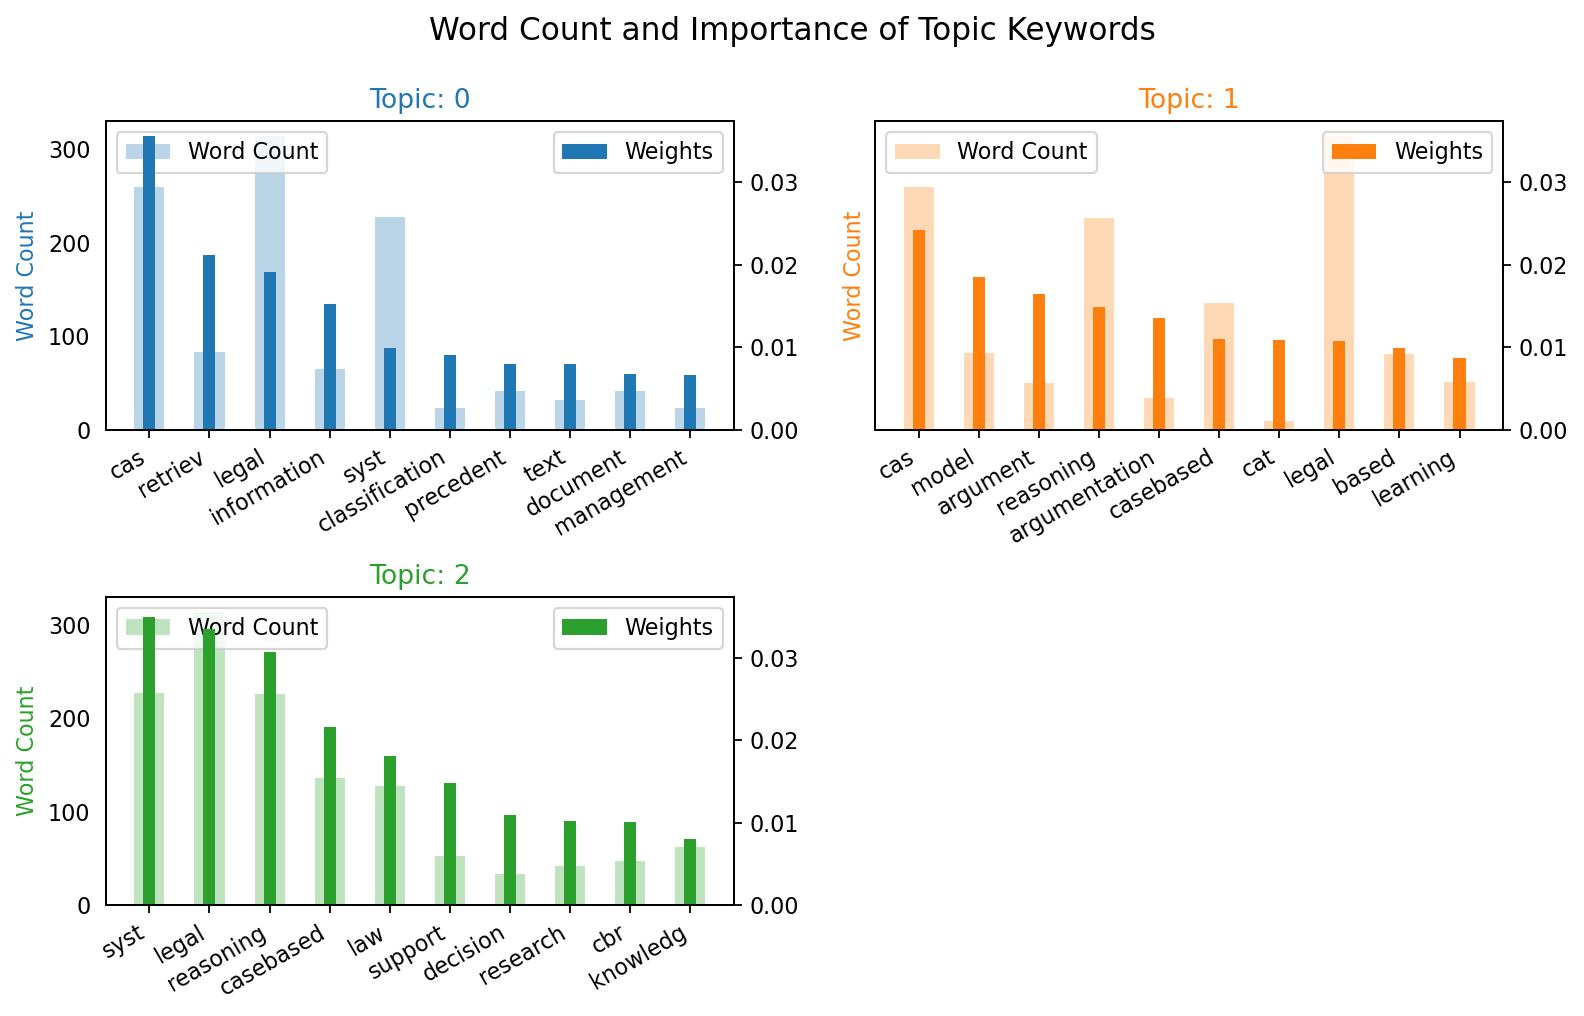

In [118]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in corpus for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(10,6), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()[0:len(topics)]):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 1.05*df['importance'].max())
    ax.set_ylim(0, 1.05*df['word_count'].max())
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=12)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=14, y=1.05)
# remove empty subplot
fig.delaxes(axes[1][1])
plt.show()

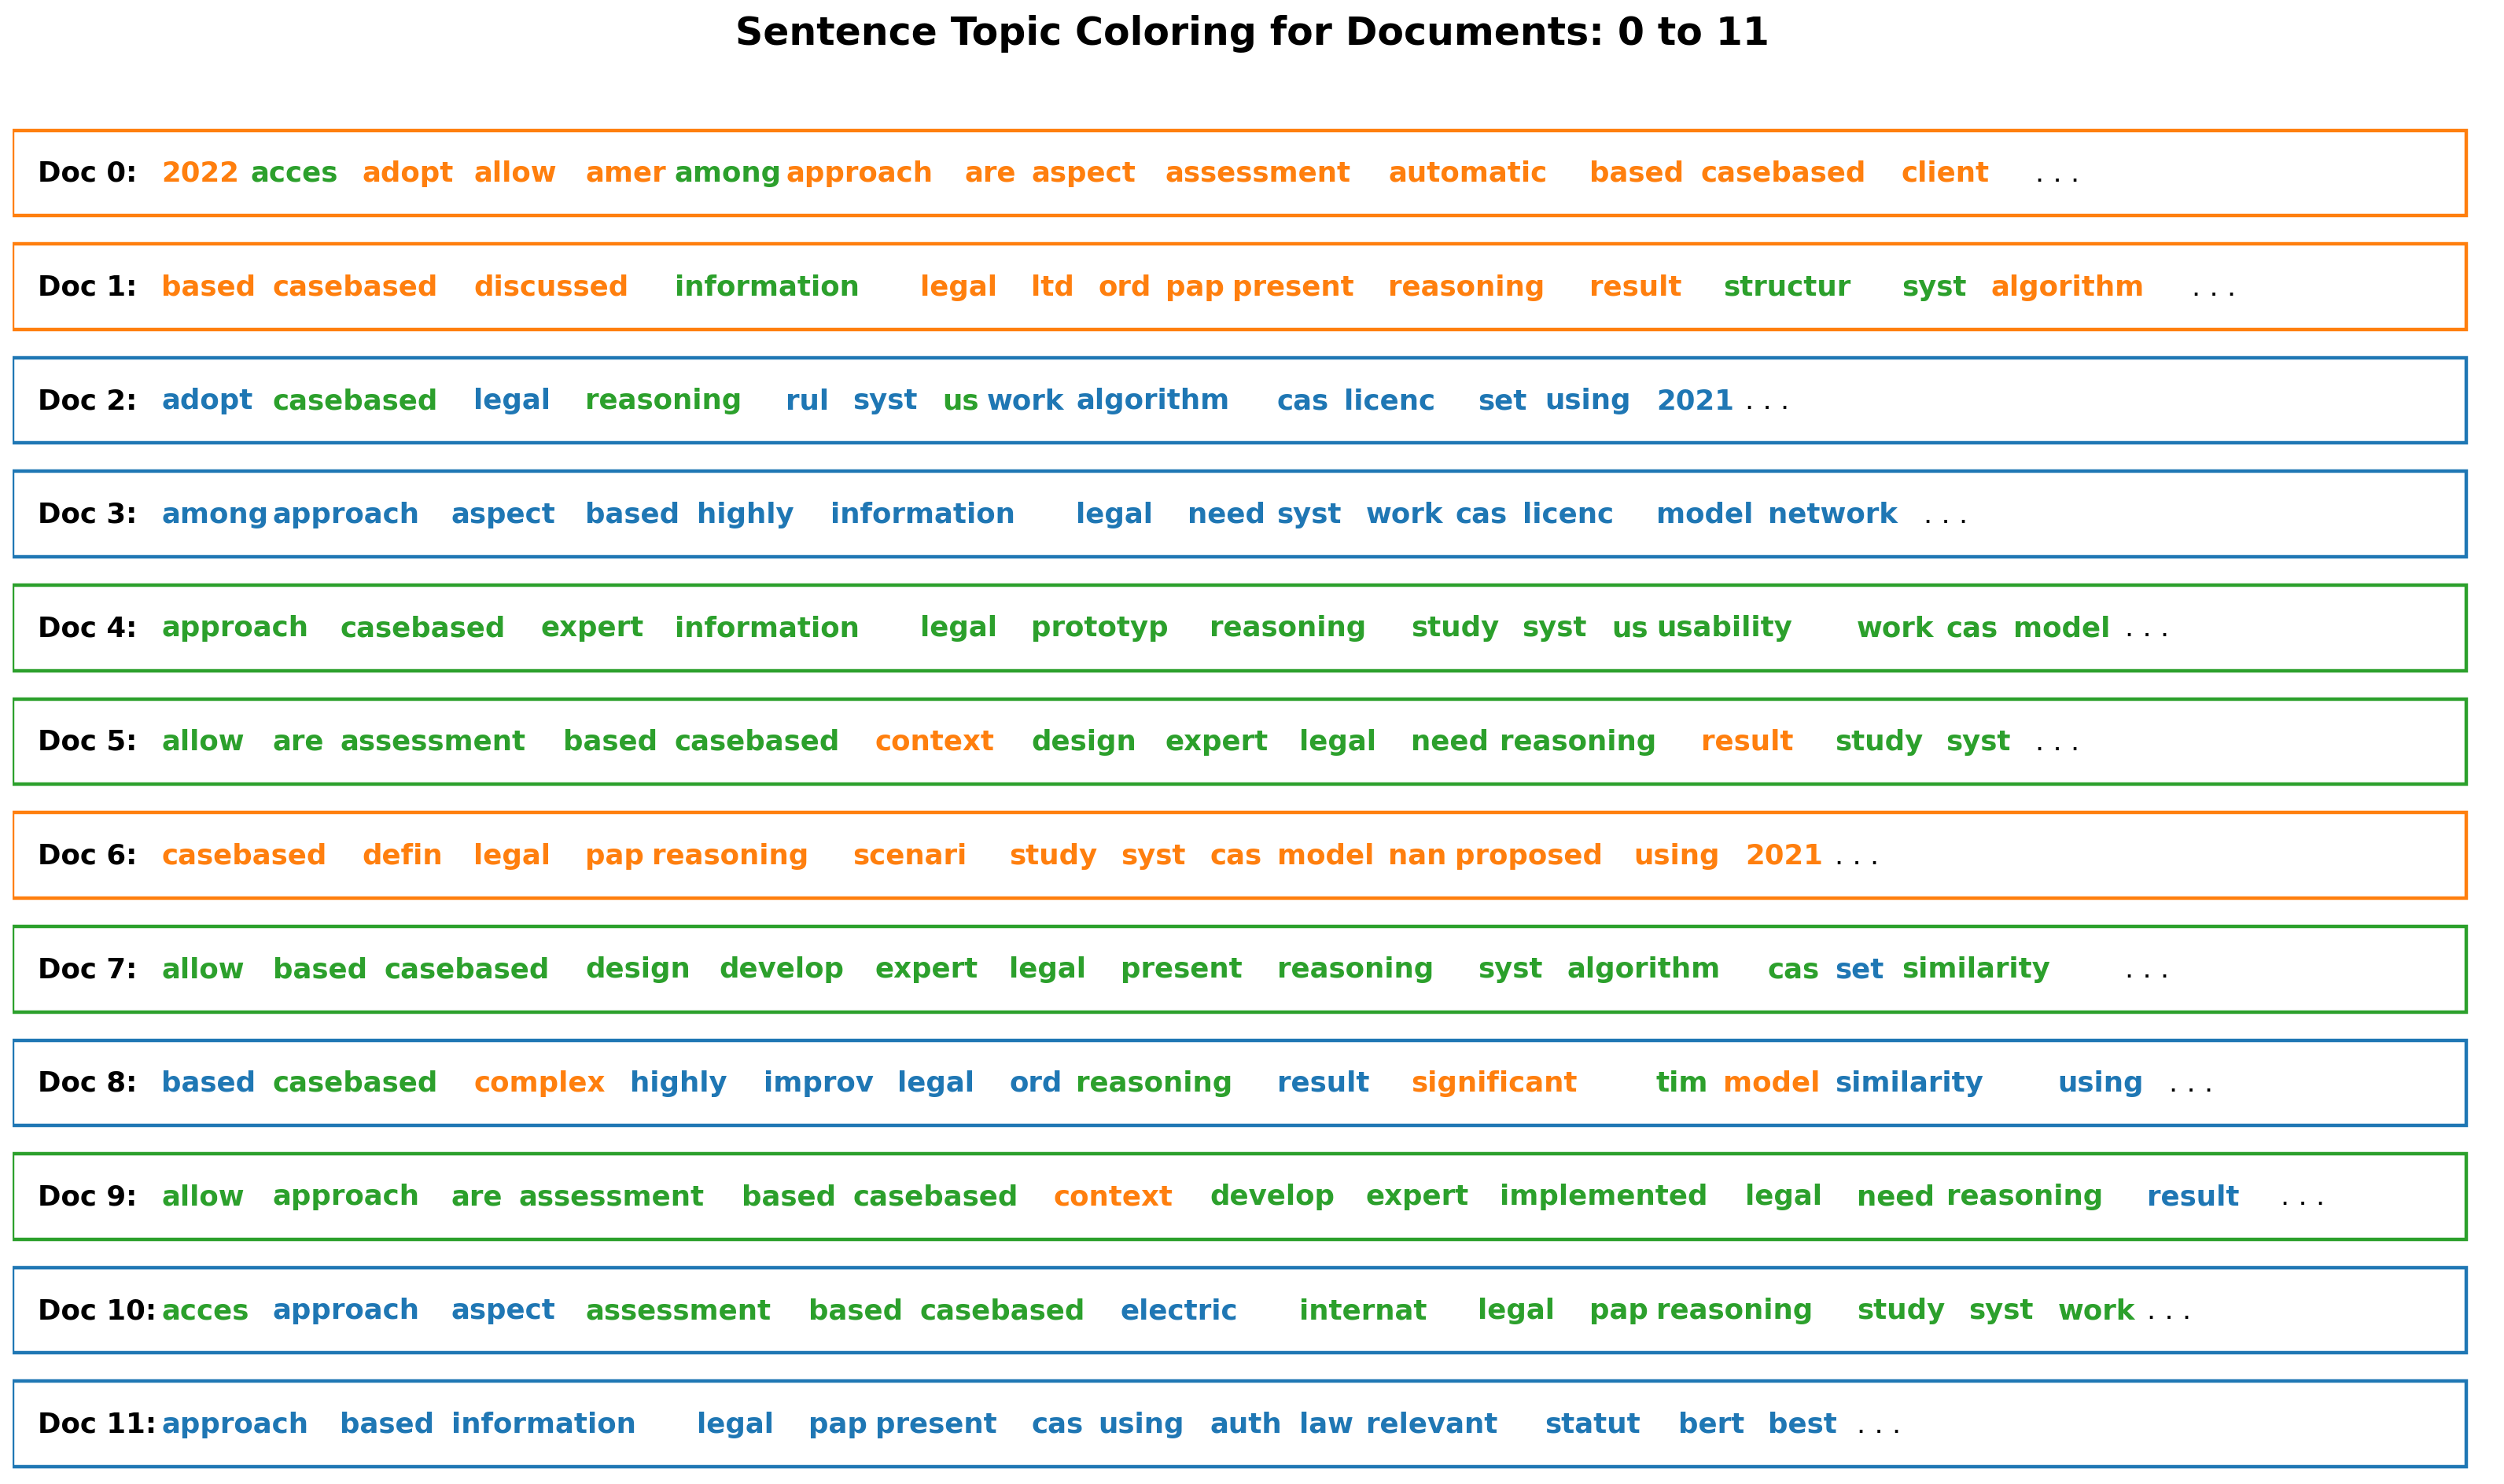

In [119]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=bow_corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

In [120]:
def format_topics_sentences(ldamodel=None, corpus=bow_corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=dsSelected['Title'].reset_index(drop=True))

In [121]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic[df_dominant_topic['Dominant_Topic'].isin([6])].shape

(0, 5)

In [122]:
df_dominant_topic[df_dominant_topic['Dominant_Topic'].isin([1])][['Dominant_Topic', 'Text']]

,Dominant_Topic,Text
0,1.0,A knowledge-based system for electric motors c...
1,1.0,Constructing the Electronic Countermeasures Sy...
6,1.0,Monotonicity and Noise-Tolerance in Case-Based...
13,1.0,An explainable approach to deducing outcomes i...
22,1.0,Explanations by arbitrated argumentative dispute
23,1.0,Legal ontologies over time: A systematic mappi...
24,1.0,Lessons from Implementing Factors with Magnitude
26,1.0,Representing dimensions within the reason mode...
28,1.0,Predicting trade secret case outcomes using ar...
39,1.0,ANGELIC Secrets: Bridging from Factors to Fact...


In [123]:
topic0 = df_dominant_topic[df_dominant_topic['Dominant_Topic'].isin([0])][['Dominant_Topic', 'Text']].index.to_list()

In [124]:
len(topic0)

28

In [125]:
topic1 = df_dominant_topic[df_dominant_topic['Dominant_Topic'].isin([1])][['Dominant_Topic', 'Text']].index.to_list()

In [126]:
topic2 = df_dominant_topic[df_dominant_topic['Dominant_Topic'].isin([2])][['Dominant_Topic', 'Text']].index.to_list()

In [127]:
for i in dsSelected.iloc[topic0]['Title']:
    print(i)

Resolving counterintuitive consequences in law using legal debugging
Unsupervised approaches for measuring textual similarity between legal court case reports
Probit regressive tversky indexed rocchio convolutive deep neural learning for legal document data analytics
5th International Conference on Advanced Machine Learning Technologies and Applications, AMLTA 2020
Artificial intelligence as legal research assistant
A study on lemma vs stem for legal information retrieval using R tidyverse. IMS UniPD @ AILA 2020 Task 1
Cases without borders: Automating knowledge acquisition approach using deep autoencoders and siamese networks in case-based reasoning
Removing named entities to find precedent legal cases
FIRE 2019 AILA track: Artificial intelligence for legal assistance
Legal statutes retrieval: A comparative approach on performance of title and statutes descriptive text
A Study of Precedent Retrieval System for Civil Trial
Similarity analysis of court judgements using association rule 

In [128]:
for i in dsSelected.iloc[topic1]['Title']:
    print(i)

A knowledge-based system for electric motors compliance verification in a multinational-level company
Constructing the Electronic Countermeasures System Architecture Based on Case-Based Reasoning and Bayesian Inference
Monotonicity and Noise-Tolerance in Case-Based Reasoning with Abstract Argumentation
An explainable approach to deducing outcomes in european court of human rights cases using ADFs
Explanations by arbitrated argumentative dispute
Legal ontologies over time: A systematic mapping study
Lessons from Implementing Factors with Magnitude
Representing dimensions within the reason model of precedent
Predicting trade secret case outcomes using argument schemes and learned antitative value eect tradeos
ANGELIC Secrets: Bridging from Factors to Facts in US Trade Secrets
Using textual case-based Reasoning in intelligent Fatawa QA system
An Expert System Approach for Legal Reasoning in Acquire Immovable Property
Argumentation Schemes for Argument from Analogy
Argumentation Schemes fo

In [129]:
for i in dsSelected.iloc[topic2]['Title']:
    print(i)

Practical tools from formal models: The ECHR as a case study
Ryel: An experimental study in the behavioral response of judges using a novel technique for acquiring higher-order thinking based on explainable artificial intelligence and case-based reasoning
Case-based Legal Reasoning and Inductive Reasoning: Determination of the input parameters using Neutrosophic AHP
RYEL System: A Novel Method for Capturing and Represent Knowledge in a Legal Domain Using Explainable Artificial Intelligence (XAI) and Granular Computing (GrC)
Explanation in AI and law: Past, present and future
Digital networks for laboratory data: Potentials, barriers and current initiatives
User-friendly open-source case-based legal reasoning
Reasoning and Representation of Legal Cases Through Ontology
On the problem of making autonomous vehicles conform to traffic law
Case-based goal trajectories for knowledge investigations
Data science techniques for law and justice: Current state of research and open problems
Is the

In [130]:
dsSelected.iloc[topic0].to_csv(join(PROJECT_ROOT, 'Results', 'topic0.csv'))

In [161]:
removedAfterScreening = [3, 10, 13, 94, 29, 73, 77, 96, 108, 142]

In [162]:
dsIncluded = dsSelected.iloc[topic0].loc[~dsSelected.iloc[topic0].index.isin(removedAfterScreening)]

In [163]:
dsIncluded['Source'].value_counts()

Scopus    17
WoS        1
Name: Source, dtype: int64

In [164]:
dsIncluded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 5 to 143
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Authors                 18 non-null     object 
 1   Author(s) ID            18 non-null     object 
 2   Title                   18 non-null     object 
 3   Year                    18 non-null     float64
 4   Source title            18 non-null     object 
 5   Volume                  15 non-null     object 
 6   Issue                   6 non-null      object 
 7   Cited by                15 non-null     float64
 8   DOI                     9 non-null      object 
 9   Affiliations            18 non-null     object 
 10  Abstract                18 non-null     object 
 11  Author Keywords         16 non-null     object 
 12  Correspondence Address  12 non-null     object 
 13  Publisher               12 non-null     object 
 14  ISSN                    14 non-null     obj

In [186]:
# manual solution of citations and countries
dsIncluded.at[130,'Country'] = 'China'
dsIncluded.at[143,'Country'] = 'China'
dsIncluded['Cited by'].fillna(0, inplace=True)

In [188]:
dsIncluded.to_csv(join(PROJECT_ROOT, 'Results', 'topic0_included.csv'))

### Creating funnel chart to represent the samples excluded in each phase

In [7]:
import plotly.express as px
stages = ["Identification", "Screening (deduplication by title/abstract equality)",
          "Screening (deduplication by title/abstract similarity)", "Screening (by keywords frequency and word clouds)",
         "Eligibility (by topic selection)", "Included (after manual screening)"]
df_scopus = pd.DataFrame(dict(Number=[126, 126, 123, 79, 26, 17], Stage=stages))
df_scopus['Source'] = 'Scopus'
df_wos = pd.DataFrame(dict(Number=[83, 27, 26, 14, 2, 1], Stage=stages))
df_wos['Source'] = 'WoS'
df = pd.concat([df_scopus, df_wos], axis=0)
fig = px.funnel(df, x='Number', y='Stage', color='Source')
fig.update_layout(
    font_family="Times New Roman",
    font_color="black",
    font_size=20,
)
fig.show()

### Descriptive analytics

In [189]:
dsTable = pd.read_csv(join(PROJECT_ROOT, 'Results', 'topic0_included.csv'))

In [190]:
dsTable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              18 non-null     int64  
 1   Authors                 18 non-null     object 
 2   Author(s) ID            18 non-null     object 
 3   Title                   18 non-null     object 
 4   Year                    18 non-null     float64
 5   Source title            18 non-null     object 
 6   Volume                  15 non-null     object 
 7   Issue                   6 non-null      object 
 8   Cited by                18 non-null     float64
 9   DOI                     9 non-null      object 
 10  Affiliations            18 non-null     object 
 11  Abstract                18 non-null     object 
 12  Author Keywords         16 non-null     object 
 13  Correspondence Address  12 non-null     object 
 14  Publisher               12 non-null     obje

In [191]:
sourceTitle = dsTable.groupby('Source title')

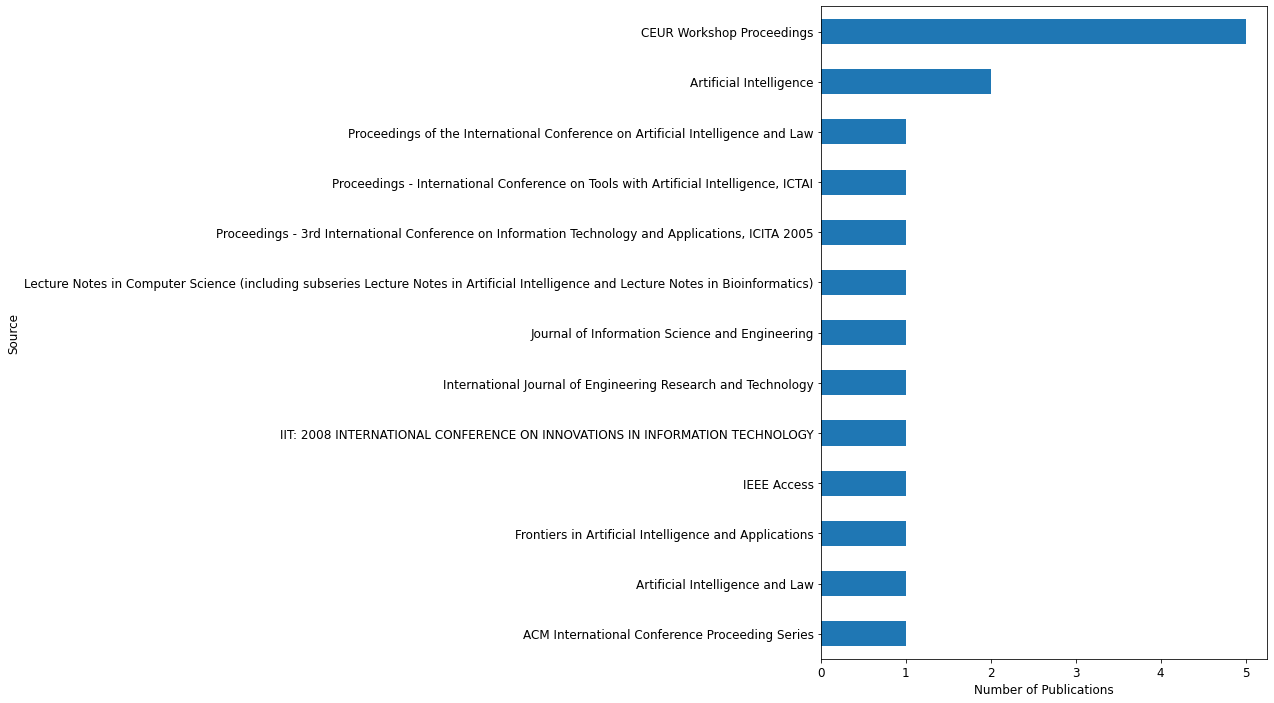

In [192]:
plt.figure(figsize=(8,12))
dsTable.groupby('Source title').size().sort_values(ascending=True).plot.barh()
plt.yticks(rotation=0, fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel("Source", fontsize=12)
plt.xlabel("Number of Publications", fontsize=12)
plt.show()

In [193]:
pubPerYearAndCountry = pd.pivot_table(dsTable, values='Authors', index='Year', columns='Country', aggfunc='count').fillna(0)
#pubPerYearAndCountry = pubPerYearAndCountry.drop('N.A.', axis = 1)

In [194]:
fields = pubPerYearAndCountry.columns.tolist()
labels = pubPerYearAndCountry.index.tolist()

In [195]:
pubPerYearAndCountry = pubPerYearAndCountry.astype(int)

In [196]:
pubPerYearAndCountry

Country,Botswana,China,Germany,India,Italy,Japan,Malaysia,New Zealand,United Kingdom,United States
Year,,,,,,,,,,
2003.0,0,1,0,0,0,0,0,0,0,2
2004.0,0,1,0,0,0,0,0,0,0,0
2005.0,0,0,0,0,0,0,0,1,0,0
2008.0,0,0,0,0,0,0,1,0,1,0
2017.0,1,1,0,1,0,0,0,0,0,0
2018.0,0,0,0,1,0,1,0,0,0,0
2019.0,0,0,1,2,0,0,0,0,0,0
2020.0,0,0,0,1,1,0,0,0,0,0
2021.0,0,0,0,1,0,0,0,0,0,0


In [197]:
li1 = [*range(2003,2022)]

li2 = pubPerYearAndCountry.index.to_list()

resultant = [i for i in li1 + li2 if i not in li1 or i not in li2]
resultant

[2006, 2007, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

In [198]:
pubPerYearAndCountry.columns.to_list()

['Botswana',
 'China',
 'Germany',
 'India',
 'Italy',
 'Japan',
 'Malaysia',
 'New Zealand',
 'United Kingdom',
 'United States']

In [199]:
for year in resultant:
    pubPerYearAndCountry = pubPerYearAndCountry.append(pd.Series([0] * pubPerYearAndCountry.shape[1],name=year,index=pubPerYearAndCountry.columns.to_list()))

In [200]:
pubPerYearAndCountry = pubPerYearAndCountry.sort_values(by='Year')

In [201]:
from matplotlib.ticker import MaxNLocator
import matplotlib
cmap = matplotlib.cm.get_cmap('Set3')

In [202]:
cmap.colors

((0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 (1.0, 1.0, 0.7019607843137254),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
 (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
 (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
 (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
 (0.7372549019607844, 0.5019607843137255, 0.7411764705882353),
 (0.8, 0.9215686274509803, 0.7725490196078432),
 (1.0, 0.9294117647058824, 0.43529411764705883))

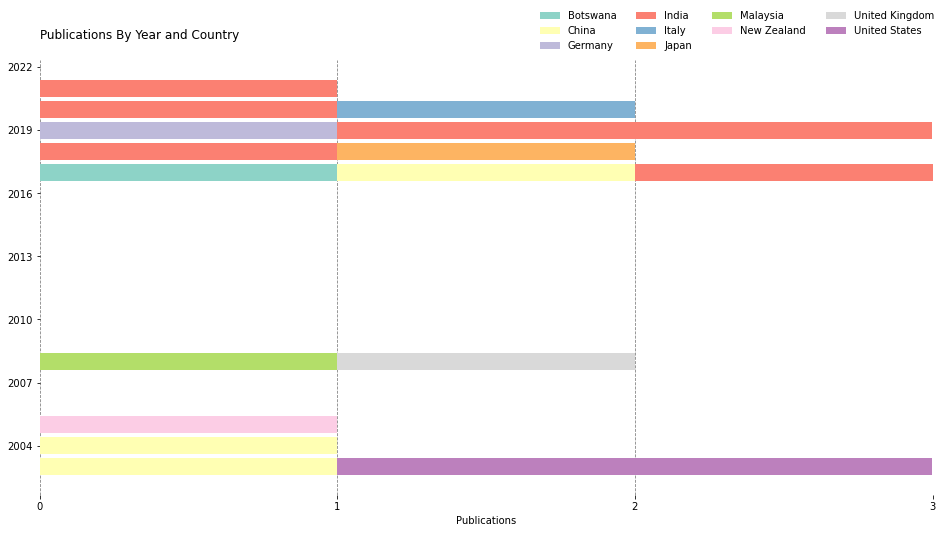

In [203]:
colors = cmap.colors

# figure and axis
fig, ax = plt.subplots(1, figsize=(16, 8))
# plot bars
left = len(pubPerYearAndCountry) * [0]
i = 0
for idx, name in enumerate(fields):
    plt.barh(pubPerYearAndCountry.index, pubPerYearAndCountry[name], left = left, color=colors[i])
    left = left + pubPerYearAndCountry[name]
    i+=1
# title, legend, labels
plt.title('Publications By Year and Country\n', loc='left')
plt.legend(fields, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Publications')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
#plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [204]:
pubPerSourceAndType = pd.pivot_table(dsTable, values='Authors', index='Source title', columns='Document Type', aggfunc='count').fillna(0)

In [205]:
pubPerSourceAndType

Document Type,Article,Conference Paper,Proceedings Paper
Source title,,,
ACM International Conference Proceeding Series,0.0,1.0,0.0
Artificial Intelligence,0.0,2.0,0.0
Artificial Intelligence and Law,1.0,0.0,0.0
CEUR Workshop Proceedings,0.0,5.0,0.0
Frontiers in Artificial Intelligence and Applications,0.0,1.0,0.0
IEEE Access,1.0,0.0,0.0
IIT: 2008 INTERNATIONAL CONFERENCE ON INNOVATIONS IN INFORMATION TECHNOLOGY,0.0,0.0,1.0
International Journal of Engineering Research and Technology,1.0,0.0,0.0
Journal of Information Science and Engineering,1.0,0.0,0.0


In [206]:
fields = pubPerSourceAndType.columns.tolist()
labels = pubPerSourceAndType.index.tolist()

In [207]:
fields

['Article', 'Conference Paper', 'Proceedings Paper']

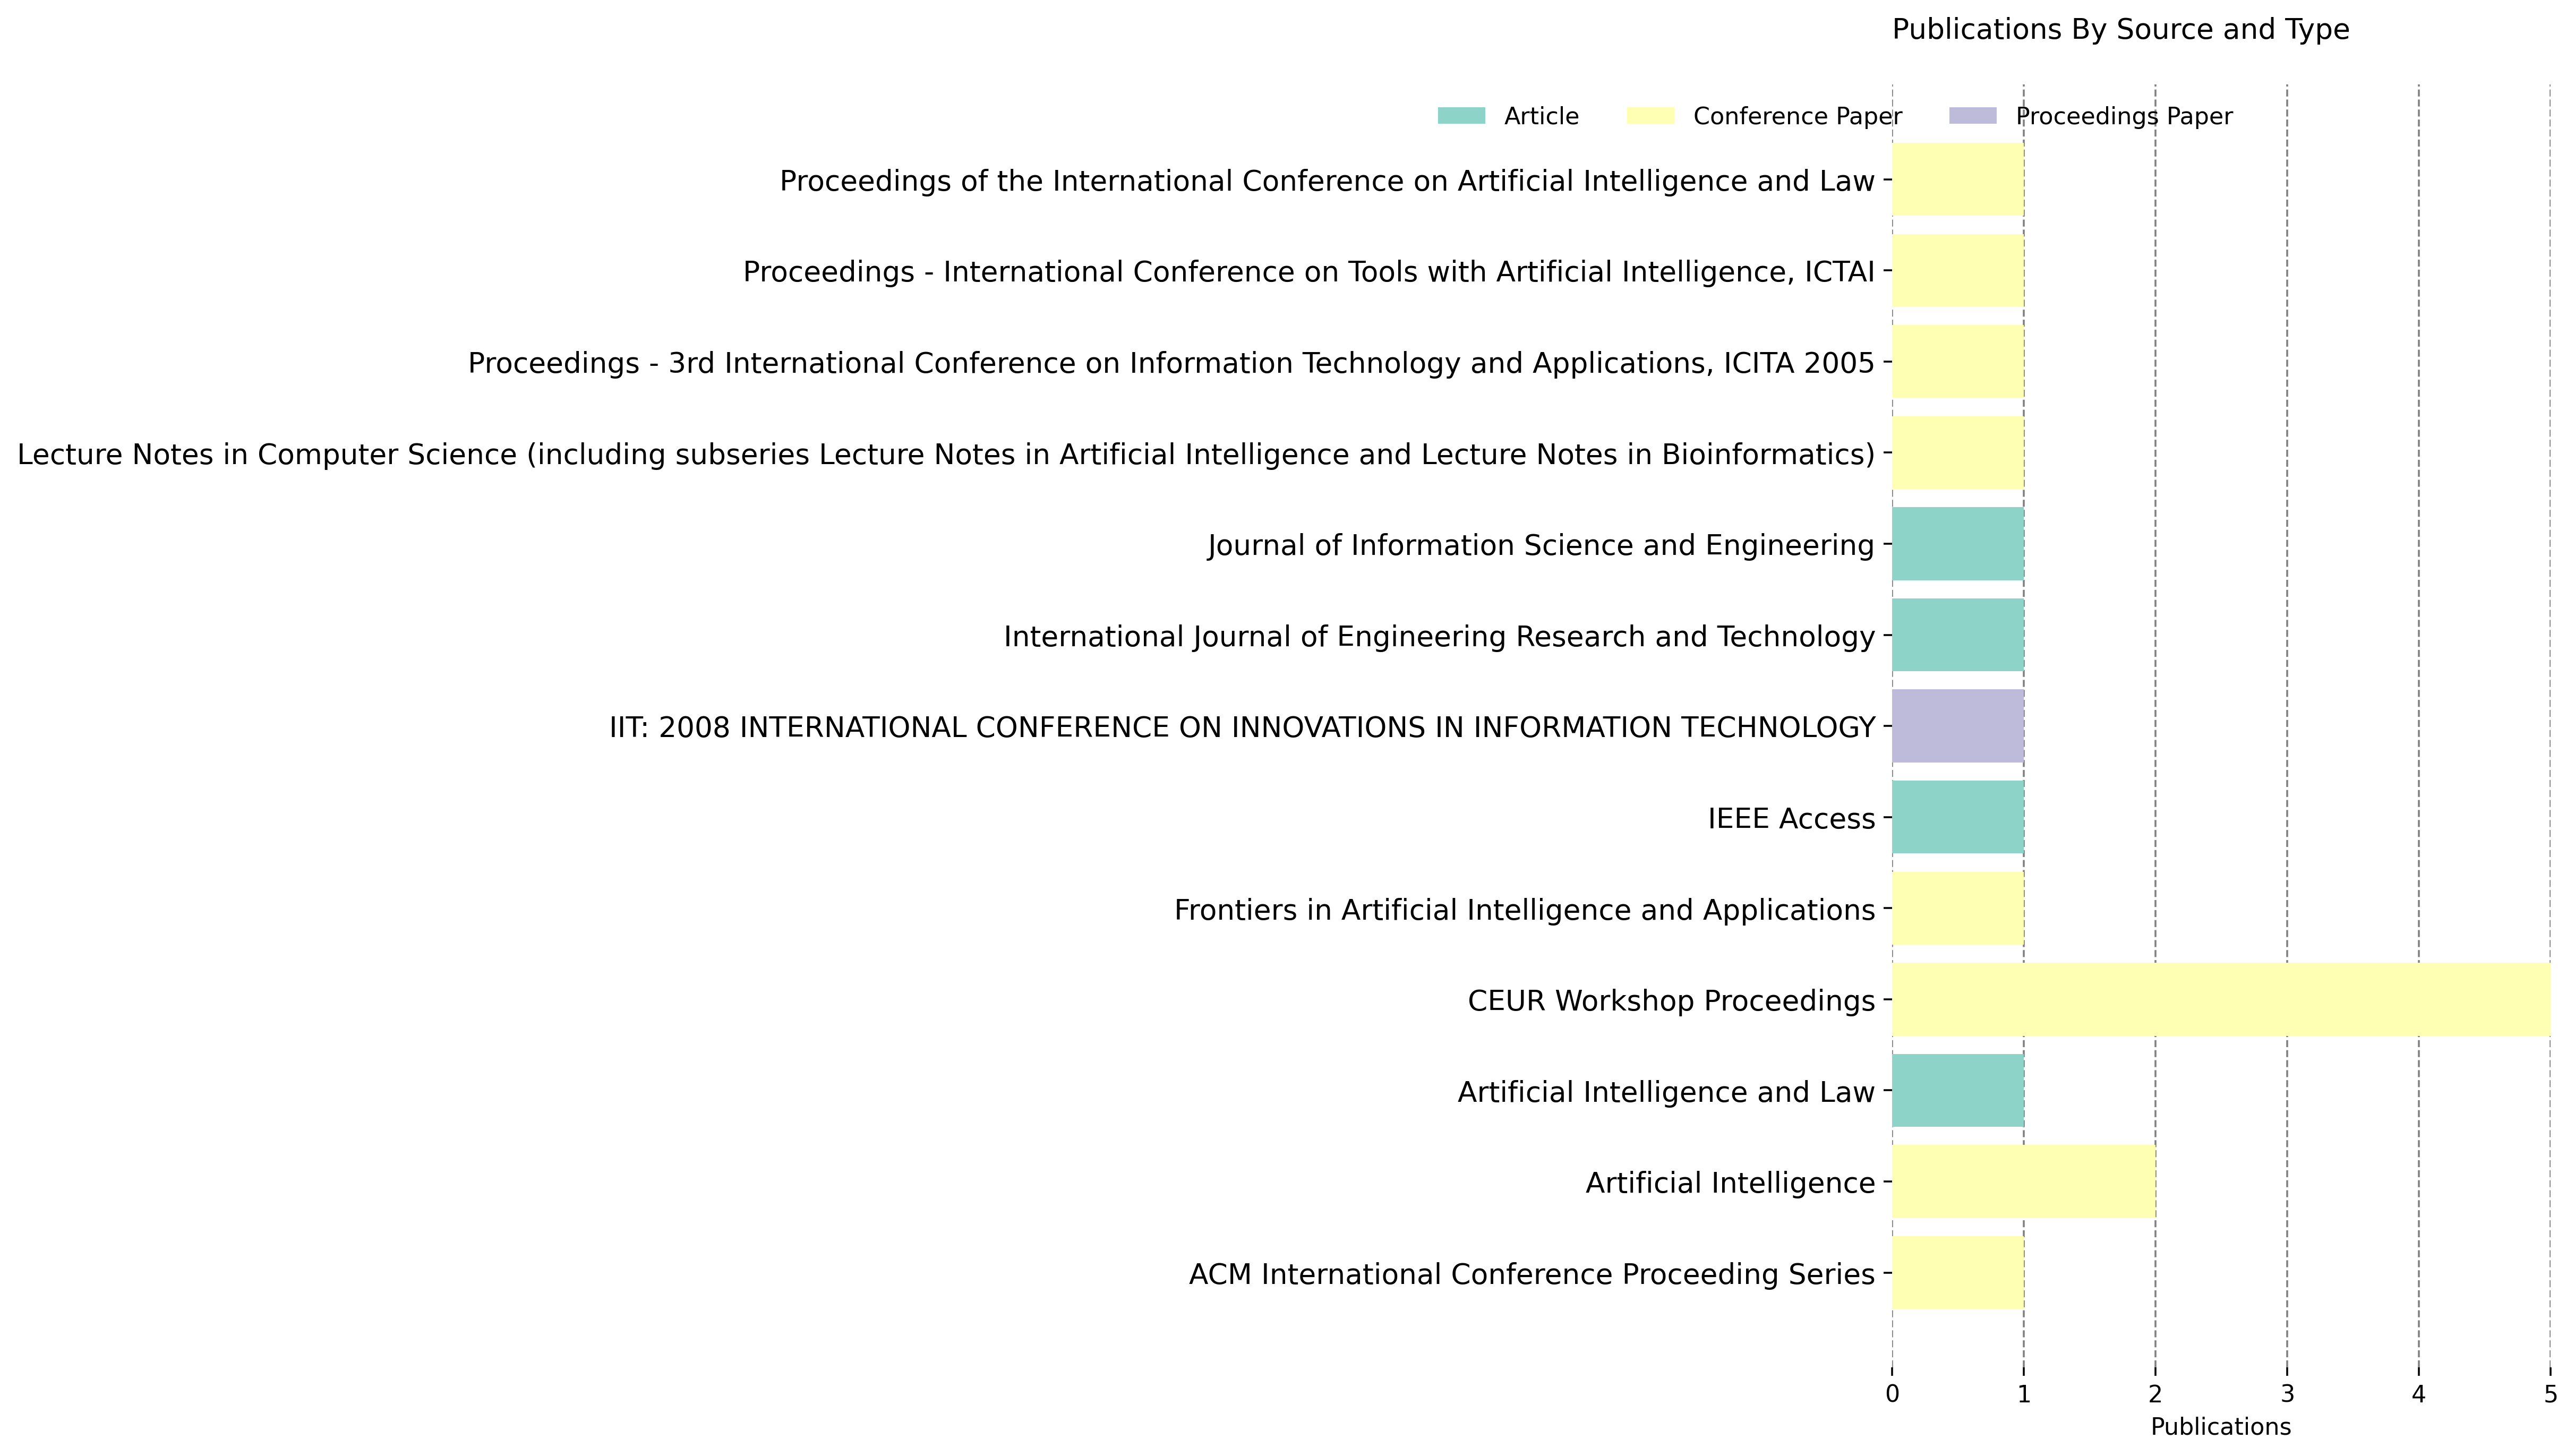

In [208]:
colors = cmap.colors

# figure and axis
fig, ax = plt.subplots(1, figsize=(5, 10), dpi=320)
# plot bars
left = len(pubPerSourceAndType) * [0]
i = 0
for idx, name in enumerate(fields):
    plt.barh(pubPerSourceAndType.index, pubPerSourceAndType[name], left = left, color=colors[i])
    left = left + pubPerSourceAndType[name]
    i+=1
# title, legend, labels
plt.title('Publications By Source and Type\n', loc='left')
plt.legend(fields, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Publications')
plt.yticks(fontsize=12)
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
#plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.yaxis.set_major_locator(MaxNLocator(integer=False))
plt.show()

In [158]:
scopus

,Authors,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,Page end,...,ISBN,CODEN,PubMed ID,Language of Original Document,Abbreviated Source Title,Document Type,Publication Stage,Open Access,Source,EID
0,"Bench-Capon T., Sartor G.",7004514001;56265404000;,A model of legal reasoning with cases incorpor...,2003,Artificial Intelligence,150,1-2,NaN,97.0,143.0,...,NaN,AINTB,NaN,English,Artif Intell,Conference Paper,Final,"All Open Access, Bronze",Scopus,2-s2.0-0142166366
1,Aleven V.,6602528401;,Using background knowledge in case-based legal...,2003,Artificial Intelligence,150,1-2,NaN,183.0,237.0,...,NaN,AINTB,NaN,English,Artif Intell,Conference Paper,Final,"All Open Access, Bronze",Scopus,2-s2.0-0142228346
2,"Ashley K.D., Brüninghaus S.",7005232254;6505857408;,Automatically classifying case texts and predi...,2009,Artificial Intelligence and Law,17,2,NaN,125.0,165.0,...,NaN,AINLE,NaN,English,Artif Intell Law,Article,Final,NaN,Scopus,2-s2.0-67849135036
3,"Bruninghaus S., Ashley K.D.",6505857408;7005232254;,Predicting outcomes of case based legal arguments,2003,Proceedings of the International Conference on...,NaN,NaN,1047838.0,233.0,242.0,...,1581137478; 9781581137477,85OAA,NaN,English,Proc Int Conf Artif Intell Law,Conference Paper,Final,NaN,Scopus,2-s2.0-29144474860
4,"Wyner A., Mochales-Palau R., Moens M.-F., Milw...",7006211789;35111581100;7005471657;6507067464;,Approaches to text mining arguments from legal...,2010,Lecture Notes in Computer Science (including s...,6036 LNAI,NaN,NaN,60.0,79.0,...,364212836X; 9783642128363,NaN,NaN,English,Lect. Notes Comput. Sci.,Conference Paper,Final,NaN,Scopus,2-s2.0-77953803535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,Rissland E.L.,6701660287;,Legal Reasoning,2008,A Companion to Cognitive Science,NaN,NaN,NaN,722.0,733.0,...,9781405164535; 9780631218517,NaN,NaN,English,A Companion to Cogn. Sci.,Book Chapter,Final,NaN,Scopus,2-s2.0-85052779982
122,Čyras V.,36908746100;,On formalisation of the goal concept in law,2007,Engineering Applications of Artificial Intelli...,20,5,NaN,601.0,608.0,...,NaN,EAAIE,NaN,English,Eng Appl Artif Intell,Article,Final,NaN,Scopus,2-s2.0-34249799566
123,"Bittencourt I.I., Costa E.B.",15924917400;35618052700;,The design and development of a tutoring syste...,2006,Proceedings of the Fifth IASTED International ...,2006,NaN,NaN,285.0,290.0,...,0889865434; 9780889865433,NaN,NaN,English,Proc. 5th IASTED Int. Conf. Web-based Educ.,Conference Paper,Final,NaN,Scopus,2-s2.0-33847178393
124,Hüllermeier E.,6701552637;,Instance-based learning of credible label sets,2003,Lecture Notes in Artificial Intelligence (Subs...,2821,NaN,NaN,450.0,464.0,...,NaN,LNAIE,NaN,English,Lect Notes Artif Intell,Conference Paper,Final,"All Open Access, Green",Scopus,2-s2.0-9444221314


In [159]:
dsTable.Title

0     Unsupervised approaches for measuring textual ...
1     Artificial intelligence as legal research assi...
2     A study on lemma vs stem for legal information...
3     Cases without borders: Automating knowledge ac...
4     Removing named entities to find precedent lega...
5     FIRE 2019 AILA track: Artificial intelligence ...
6     A Study of Precedent Retrieval System for Civi...
7     Similarity analysis of court judgements using ...
8     On the importance of legal catchphrases in pre...
9     Detection of catchphrases and precedence in le...
10     An Ontological Chinese Legal Consultation System
11    Towards Annotating and Extracting Textual Lega...
12    Concept and context in legal information retri...
13    COMPUTER AIDED LEGAL SUPPORT SYSTEM: An Initia...
14    Nonlinear nearest-neighbour matching and its a...
15    Case instance generation and refinement for ca...
16    Extensionally defining principles and cases in...
17    A reduction-graph model of precedent in le